# Linear Learner Model

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

In [2]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [3]:
data_dir = 'data'

In [9]:
train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None).values
validation_data = pd.read_csv(os.path.join(data_dir, 'validation.csv'), header=None).values

In [10]:
X_train = train_data[:,1:]
y_train = train_data[:,0]

X_validation = validation_data[:,1:]
y_validation = validation_data[:,0]

In [36]:
# import LinearLearner
from sagemaker import LinearLearner

# specify an output path
prefix = 'vehicles'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate LinearLearner
linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='regressor',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=300, 
                       optimizer='adam')

In [37]:
X_train_np = X_train.astype('float32')
y_train_np = y_train.astype('float32')

formatted_train_data = linear.record_set(X_train_np, labels=y_train_np)

X_validation_np = X_validation.astype('float32')
y_validation_np = y_validation.astype('float32')

formatted_validation_data = linear.record_set(X_validation_np, labels=y_validation_np, channel='validation')

In [38]:
linear.fit([formatted_train_data,formatted_validation_data])

2020-03-24 03:28:04 Starting - Starting the training job...
2020-03-24 03:28:06 Starting - Launching requested ML instances......
2020-03-24 03:29:07 Starting - Preparing the instances for training......
2020-03-24 03:30:29 Downloading - Downloading input data
2020-03-24 03:30:29 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/24/2020 03:30:46 INFO 139817266292544] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_

In [39]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-----------------!

In [40]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def predict(predictor, features, batch_size=100):    
    prediction_batches = [predictor.predict(batch) for batch in chunks(features, batch_size)]
    
    predictions = np.concatenate([np.array([x.label['score'].float32_tensor.values[0] for x in batch])
                                  for batch in prediction_batches])
    
    return predictions

In [41]:
X_test = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None).values
y_test = pd.read_csv(os.path.join(data_dir, 'test_y.csv'), header=None).values

X_test_np = X_test.astype('float32')
y_test_np = y_test.astype('float32')

In [42]:
predictions = predict(linear_predictor, X_test_np)

predictions

array([14523.54296875, 23189.86523438, 17252.3828125 , ...,
       28979.04492188, 18321.359375  , 18396.33789062])

In [43]:
linear_predictor.delete_endpoint()

In [44]:
labels = np.squeeze(y_test_np)

Text(0.5, 1.0, 'True Price vs Predicted Price')

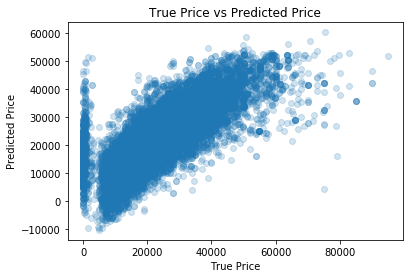

In [45]:
plt.scatter(labels, predictions, alpha=1/5)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True Price vs Predicted Price")

In [46]:
from sklearn.metrics import r2_score

score = r2_score(labels, predictions)

print('R-squared score: {}'.format(score))

R-squared score: 0.5952761649943135


In [47]:
distances = np.abs(labels - predictions)

max_distance = np.max(distances)
min_distance = np.min(distances)
mean_distance = np.mean(distances)

print('Min distance: {}'.format(min_distance))
print('Max distance: {}'.format(max_distance))
print('Mean distance: {}'.format(mean_distance))

Min distance: 0.13671875
Max distance: 70640.443359375
Mean distance: 5081.861694993801
